# PROBLEM STATEMENT

- Dataset consists of 3000 Amazon customer reviews, star ratings, date of review, variant and feedback of various amazon Alexa products like Alexa Echo, Echo dots.

- The objective is to discover insights into consumer reviews and perfrom sentiment analysis on the data.

# Step 1: Data reading and insight

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style('whitegrid')
plt.style.use('seaborn-deep')

import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
import random


seed = 12
np.random.seed(seed)

from datetime import date

In [16]:
alexa = pd.read_csv('../input/amazon-alexa-reviews/amazon_alexa.tsv', sep='\t')
alexa.head(5)

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [17]:
# important funtions
def datasetShape(df):
    rows, cols = df.shape
    print("The dataframe has",rows,"rows and",cols,"columns.")
    
# select numerical and categorical features
def divideFeatures(df):
    numerical_features = df.select_dtypes(include=[np.number]).drop('feedback', axis=1)
    categorical_features = df.select_dtypes(include=[np.object])
    return numerical_features, categorical_features

In [4]:
alexa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3150 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [5]:
alexa.describe()

,rating,feedback
count,3150.000000,3150.000000
mean,4.463175,0.918413
std,1.068506,0.273778
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


# Step 2: EDA

In [6]:
# check null values

pd.DataFrame(alexa.isnull().sum(), columns=["Null Count"]).style.background_gradient(cmap='Blues')

,Null Count
rating,0
date,0
variation,0
verified_reviews,0
feedback,0


In [18]:
numerical_features, categorical_features = divideFeatures(alexa)

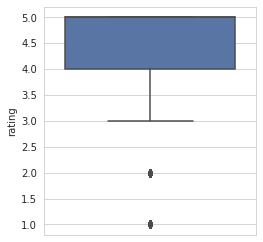

In [8]:
# boxplots of numerical features for outlier detection

fig = plt.figure(figsize=(16,30))
for i in range(len(numerical_features.columns)):
    fig.add_subplot(9, 5, i+1)
    sns.boxplot(y=numerical_features.iloc[:,i])
plt.tight_layout()
plt.show()

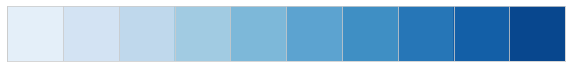

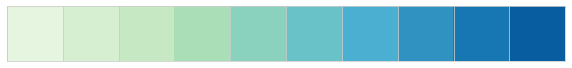

In [9]:
sns.color_palette("Blues", as_cmap=True)
GnBu_palette = sns.color_palette("GnBu",10)
Blues_palette = sns.color_palette("Blues",10)
sns.palplot(Blues_palette)
sns.palplot(GnBu_palette)

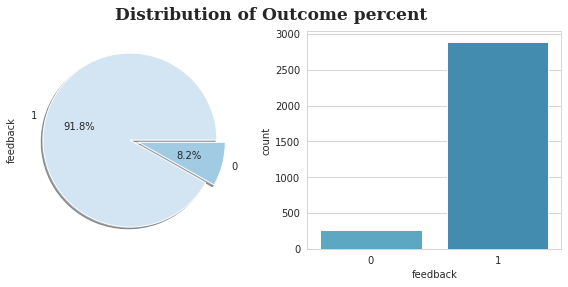

In [10]:
fig, axes = plt.subplots(1,2,figsize=(10,4))

alexa['feedback'].value_counts().plot.pie(
    explode=[0,0.1],autopct='%1.1f%%',ax=axes[0],shadow=True, colors=[Blues_palette[1],Blues_palette[3]]
)

sns.countplot('feedback',data=alexa,ax=axes[1], palette=[GnBu_palette[6],GnBu_palette[7]])
axes[1].patch.set_alpha(0)

fig.text(0.28,0.92,"Distribution of Outcome percent", fontweight="bold", fontfamily='serif', fontsize=17)

plt.show()

Highly unbalanced class

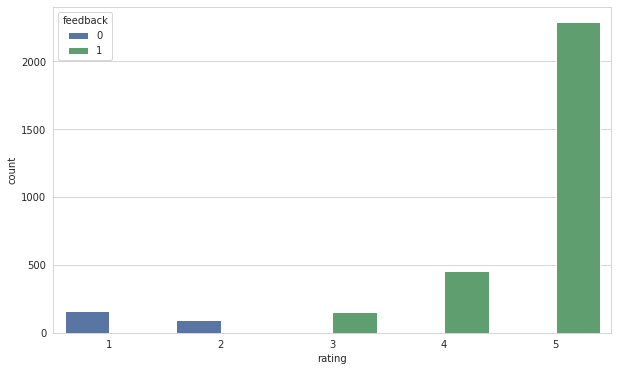

In [11]:
# Distribution of discrete data over output column


plt.figure(figsize = (10,6))
sns.countplot(x = 'rating', hue = 'feedback', data=alexa)
fig.show()

- The figure above shows evidence of positive feedback with a rating of 5

In [12]:
alexa[alexa.columns[:5]].corr().style.background_gradient(cmap='Blues')

,rating,feedback
rating,1.000000,0.861968
feedback,0.861968,1.000000


- 86% correlation between rating and feedback

# Step 3: Data Cleaning

In [22]:
# select verified_reviews and drop the date 

verified_reviews = alexa.iloc[:,3:4]

alexa.drop(['date', 'verified_reviews'], axis=1, inplace=True)

# Step 4: Data Preparation

In [23]:
# extract all skewed features
temp_numerical_features, temp_categorical_features = divideFeatures(alexa)
# remove categorical features stored as int
temp_numerical_features.drop(['rating'], axis=1, inplace=True)
skewed_features = temp_numerical_features.apply(lambda x: x.skew()).sort_values(ascending=False)

In [24]:
# transform skewed features
for feat in skewed_features.index:
    if skewed_features.loc[feat] > 0.5:
        alexa[feat] = np.log1p(alexa[feat])

In [25]:
# outlier treatment for categorical features
def getCategoricalSkewed(categories, threshold):
    tempSkewedFeatures = []
    for feat in categories:
        for featValuePerc in list(alexa[feat].value_counts()/alexa.shape[0]):
            if featValuePerc > threshold:
                tempSkewedFeatures.append(feat)
    return list(set(tempSkewedFeatures))

# display all categorical skewed features which have value_counts > 90%
categoricalSkewed = getCategoricalSkewed(temp_categorical_features.columns, .90)
for feat in categoricalSkewed:
    print(alexa[feat].value_counts()/len(alexa))
    print()

No skewed categorical features

In [26]:
# extract numerical and categorical for dummy and scaling later

categorical_features.drop(['date','verified_reviews'], axis=1, inplace=True)

numerical_features, categorical_features = divideFeatures(alexa)
for feat in categorical_features.columns:
    dummyVars = pd.get_dummies(alexa[feat], drop_first=True, prefix=feat+"_")
    alexa = pd.concat([alexa, dummyVars], axis=1)
    alexa.drop(feat, axis=1, inplace=True)

datasetShape(alexa)

The dataframe has 3150 rows and 17 columns.


In [27]:
alexa.describe()

,rating,feedback,variation__Black Dot,variation__Black Plus,variation__Black Show,variation__Black Spot,variation__Charcoal Fabric,variation__Configuration: Fire TV Stick,variation__Heather Gray Fabric,variation__Oak Finish,variation__Sandstone Fabric,variation__Walnut Finish,variation__White,variation__White Dot,variation__White Plus,variation__White Show,variation__White Spot
count,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000
mean,4.463175,0.918413,0.163810,0.085714,0.084127,0.076508,0.136508,0.111111,0.049841,0.004444,0.028571,0.002857,0.028889,0.058413,0.024762,0.026984,0.034603
std,1.068506,0.273778,0.370161,0.279986,0.277622,0.265851,0.343382,0.314320,0.217651,0.066529,0.166625,0.053384,0.167521,0.234559,0.155423,0.162063,0.182802
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
alexa_countvectorizer = vectorizer.fit_transform(verified_reviews['verified_reviews'])

In [32]:
alexa_countvectorizer.shape

(3150, 4044)

In [33]:
type(alexa_countvectorizer)

scipy.sparse.csr.csr_matrix

In [35]:
print(alexa_countvectorizer.toarray())  

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [37]:
reviews = pd.DataFrame(alexa_countvectorizer.toarray())

# Now let's concatenate them together
alexa = pd.concat([alexa, reviews], axis=1)

# Step 5: Modelling

Split Train-Test Data

In [39]:
# shuffle samples
df_shuffle = alexa.sample(frac=1, random_state=seed).reset_index(drop=True)

In [40]:
df_y = df_shuffle.pop('feedback')
df_X = df_shuffle

# split into train dev and test
X_train, X_test, y_train, y_test = skms.train_test_split(df_X, df_y, train_size=0.7, random_state=seed)
print(f"Train set has {X_train.shape[0]} records out of {len(df_shuffle)} which is {round(X_train.shape[0]/len(df_shuffle)*100)}%")
print(f"Test set has {X_test.shape[0]} records out of {len(df_shuffle)} which is {round(X_test.shape[0]/len(df_shuffle)*100)}%")

Train set has 2205 records out of 3150 which is 70%
Test set has 945 records out of 3150 which is 30%


In [42]:
smote = SMOTE()
X_over, y_over = smote.fit_resample(X_train,y_train)

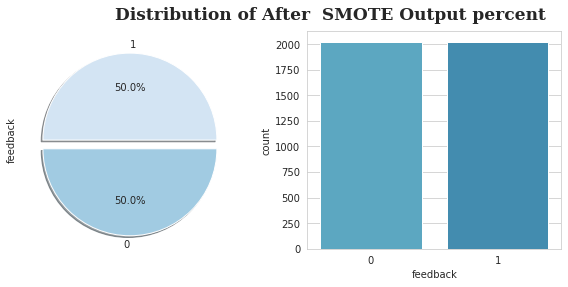

In [43]:
fig, axes = plt.subplots(1,2,figsize=(10,4))

y_over.value_counts().plot.pie(
    explode=[0,0.1],autopct='%1.1f%%',ax=axes[0],shadow=True, colors=[Blues_palette[1],Blues_palette[3]]
)

sns.countplot(y_over, ax=axes[1], palette=[GnBu_palette[6],GnBu_palette[7]])
axes[1].patch.set_alpha(0)

fig.text(0.28,0.92,"Distribution of After  SMOTE Output percent", fontweight="bold", fontfamily='serif', fontsize=17)

plt.show()

**Before SMOTE**

In [44]:
# Evaluation function definition

def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix(y_test, pred)
    accuacy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    print('confusion')
    print(confusion)
    print('accuracy : {}'.format(np.around(accuacy,4)))
    print('precision: {}'.format(np.around(precision,4)))
    print('recall : {}'.format(np.around(recall,4)))
    print('F1 : {}'.format(np.around(f1,4)))  
    print('ROC_AUC : {}'.format(np.around(roc_auc,4)))

Logistic Regression Model

In [45]:
lg_reg = LogisticRegression()

lg_reg.fit(X_train, y_train)
pred = lg_reg.predict(X_test)
pred_proba = lg_reg.predict_proba(X_test)[:,1]
get_clf_eval(y_test, pred, pred_proba)

confusion
[[ 75   1]
 [  1 868]]
accuracy : 0.9979
precision: 0.9988
recall : 0.9988
F1 : 0.9988
ROC_AUC : 1.0


Random Forest Model

In [46]:
rf_clf = RandomForestClassifier()
param = {'n_estimators' : [100],
         'max_depth':[8,9,10],
         'min_samples_split':[2,5,7],
         'min_samples_leaf':[6.5,7,7.5]
        }

In [47]:
grid = GridSearchCV(rf_clf,param_grid = param,scoring = 'accuracy',cv=5)
grid.fit(X_train ,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [8, 9, 10],
                         'min_samples_leaf': [6.5, 7, 7.5],
                         'min_samples_split': [2, 5, 7],
                         'n_estimators': [100]},
             scoring='accuracy')

In [48]:
grid.best_params_

{'max_depth': 8,
 'min_samples_leaf': 7,
 'min_samples_split': 2,
 'n_estimators': 100}

In [49]:
grid.best_score_

0.9179138321995465

In [50]:
pred = grid.predict(X_test)
pred_proba = grid.predict_proba(X_test)[:,1]
get_clf_eval(y_test, pred, pred_proba)

confusion
[[  0  76]
 [  0 869]]
accuracy : 0.9196
precision: 0.9196
recall : 1.0
F1 : 0.9581
ROC_AUC : 0.9386


SGD Classification Model

In [53]:
from sklearn.linear_model import SGDClassifier

clf_SGD = SGDClassifier(loss="squared_loss", penalty="l2", max_iter=4500,tol=-1000, random_state=1)
clf_SGD.fit(X_train,y_train)
pred = clf_SGD.predict(X_test)
pred_proba = lg_reg.predict_proba(X_test)[:,1]
get_clf_eval(y_test, pred, pred_proba)

confusion
[[ 33  43]
 [206 663]]
accuracy : 0.7365
precision: 0.9391
recall : 0.7629
F1 : 0.8419
ROC_AUC : 1.0


**After SMOTE**

In [54]:
lg_reg = LogisticRegression()

lg_reg.fit(X_over, y_over)
pred = lg_reg.predict(X_test)
pred_proba = lg_reg.predict_proba(X_test)[:,1]
get_clf_eval(y_test, pred, pred_proba)

confusion
[[ 76   0]
 [  1 868]]
accuracy : 0.9989
precision: 1.0
recall : 0.9988
F1 : 0.9994
ROC_AUC : 1.0


Random Forest Model

In [55]:
rf_clf = RandomForestClassifier()
param = {'n_estimators' : [200],
         'max_depth':[10],
         'min_samples_split':[2],
         'min_samples_leaf':[7]
        }

In [56]:
grid = GridSearchCV(rf_clf,param_grid = param,scoring = 'accuracy',cv=5)
grid.fit(X_over ,y_over)

pred = grid.predict(X_test)
pred_proba = grid.predict_proba(X_test)[:,1]
get_clf_eval(y_test, pred, pred_proba)

confusion
[[ 45  31]
 [ 44 825]]
accuracy : 0.9206
precision: 0.9638
recall : 0.9494
F1 : 0.9565
ROC_AUC : 0.885


SGD Classification Model

In [57]:
from sklearn.linear_model import SGDClassifier

clf_SGD = SGDClassifier(loss="squared_loss", penalty="l2", max_iter=4500,tol=-1000, random_state=1)
clf_SGD.fit(X_over,y_over)
pred = clf_SGD.predict(X_test)
pred_proba = lg_reg.predict_proba(X_test)[:,1]
get_clf_eval(y_test, pred, pred_proba)

confusion
[[ 59  17]
 [650 219]]
accuracy : 0.2942
precision: 0.928
recall : 0.252
F1 : 0.3964
ROC_AUC : 1.0


**Final considerations**

Logistic regression after SMOTE is the best model with the following performance:


confusion:

    [[ 76   0]

    [  1 868]]
 
accuracy: 0.9989

precision: 1.0

recall : 0.9988

F1 : 0.9994

ROC_AUC : 1.0